# House Prices data from Kaggle

Based on [housing data from Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) and the great O'Reilly book [Hands-On Machine Learning with Scikit-Learn and TensorFlow](http://shop.oreilly.com/product/0636920052289.do) from Aurélien Géron, with its [detailed examples](https://github.com/ageron/handson-ml).

*Todo* improve with steps from [tutorials in Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques#tutorials).

In [24]:
import re
import numpy as np
from pathlib import Path 
import pandas as pd
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer, StandardScaler
%matplotlib inline

In [2]:
HOUSING_DATA_PATH = Path("datasets/housing")

def load_housing_data(path=HOUSING_DATA_PATH):
    for name in ("train", "test"):
        csv_path = path / f"{name}.csv"
        yield pd.read_csv(csv_path)

train, test = load_housing_data()
train.shape, test.shape

((1460, 81), (1459, 80))

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

Variables definitions without categories.

In [5]:
with open(HOUSING_DATA_PATH / "data_description.txt") as f:
    print(''.join(line for line in f if not line[0].isspace()))

MSSubClass: Identifies the type of dwelling involved in the sale.	
MSZoning: Identifies the general zoning classification of the sale.
LotFrontage: Linear feet of street connected to property
LotArea: Lot size in square feet
Street: Type of road access to property
Alley: Type of alley access to property
LotShape: General shape of property
LandContour: Flatness of the property
Utilities: Type of utilities available
LotConfig: Lot configuration
LandSlope: Slope of property
Neighborhood: Physical locations within Ames city limits
Condition1: Proximity to various conditions
Condition2: Proximity to various conditions (if more than one is present)
BldgType: Type of dwelling
HouseStyle: Style of dwelling
OverallQual: Rates the overall material and finish of the house
OverallCond: Rates the overall condition of the house
YearBuilt: Original construction date
YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
RoofStyle: Type of roof
RoofMatl: Roof material
Ext

*Todo* apply `log` on some variables.

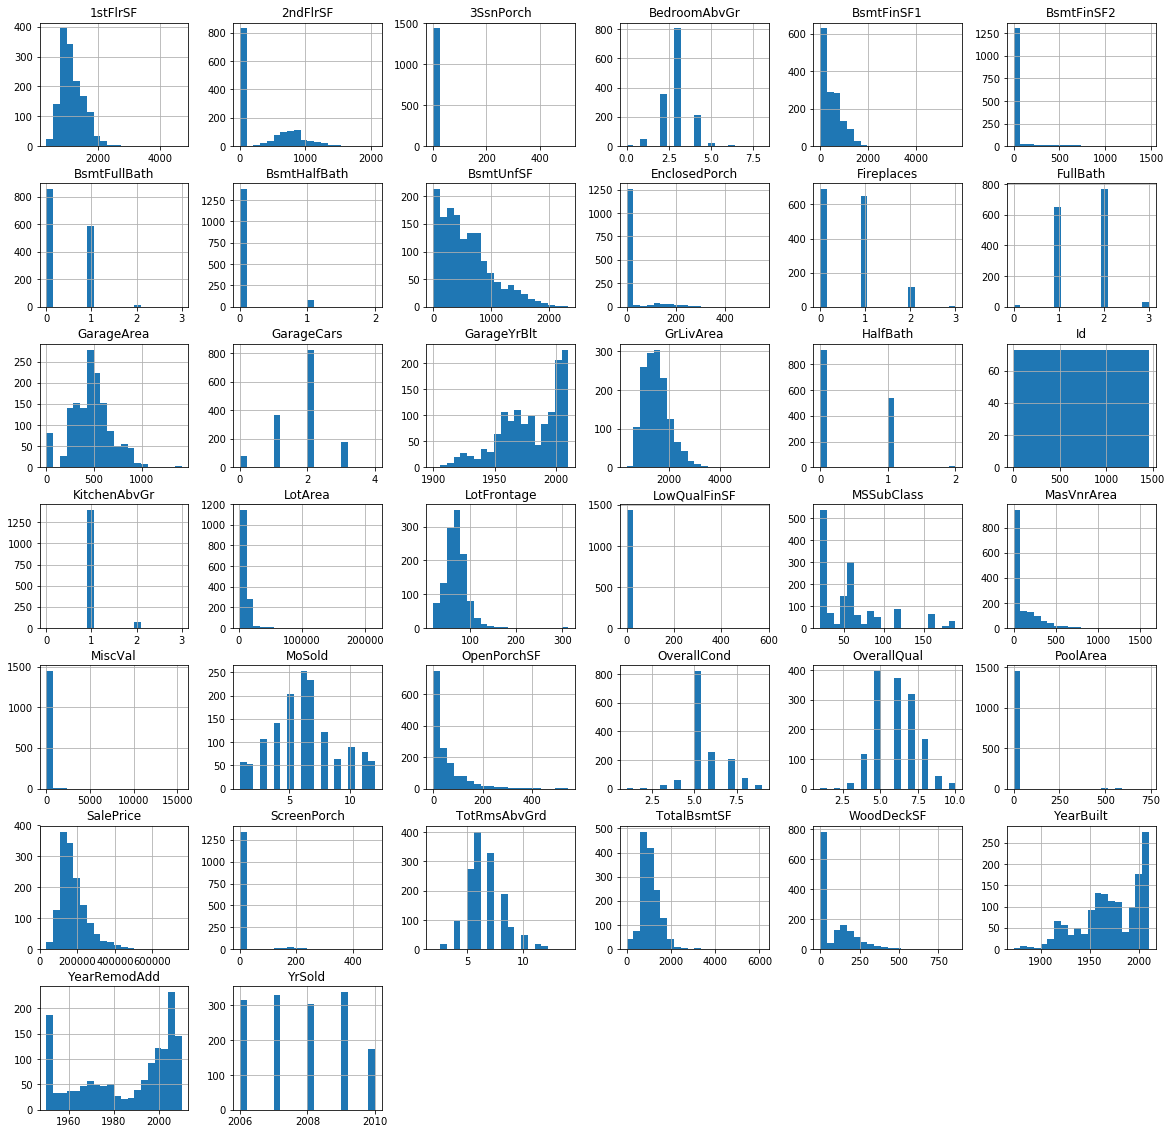

In [6]:
train.hist(bins=20, figsize=(20,20));

In [7]:
train.corr()['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

# Data cleaning

Extract categories from data description in [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

In [8]:
def removeNA(v):
    """Remove NA from categories, always in last position."""
    return v[:-1] if v[-1] == 'NA' else v

def extract_cat(descr_string):
    """Extract categories, except NA, from data_description."""
    categories = {m.group(1): re.findall(r'([a-zA-Z0-9.]+).+$', m.group(2), re.MULTILINE)
              for m in re.finditer(r'^(\w+).*\n[ \t]*\n((?:[ \t]+.+\n)+)', descr_string, re.MULTILINE)}
    return {c: CategoricalDtype(categories=removeNA(v), ordered=True) for (c, v) in categories.items()}
    

class Categorizer(BaseEstimator, TransformerMixin):
    """Cast to pandas categories after correcting values."""
    def __init__(self, replace_dict=None, catcols_dict=None):
        self.replace_dict = replace_dict if not replace_dict else {}
        if catcols_dict:
            self.catcols_dict = catcols_dict
        else:
            with open(HOUSING_DATA_PATH / "data_description.txt") as f:
                self.catcols_dict = extract_cat(f.read())
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = (X.replace(self.replace_dict)
             .astype(str) # for int64 values
             .apply(lambda s: pd.Categorical(s, dtype=self.catcols_dict[s.name])))
        return X
    
categorizer = Categorizer()

In [9]:
def no_enc_errors(df):
    """Find potential encoding errors in DataFrame with respect to data_description."""
    ok = True
    for col in df:
        s = df[col]
        cat = categorizer.catcols_dict[col].categories
        diff = pd.Categorical(s).categories.difference(cat)
        if diff.any():
            print(f"{col}: {diff.tolist()}, {cat.tolist()}".format(col, diff))
            ok = False
    return ok

no_enc_errors(train.select_dtypes(exclude=['int64', 'float64']))

MSZoning: ['C (all)'], ['A', 'C', 'FV', 'I', 'RH', 'RL', 'RP', 'RM']
Neighborhood: ['NAmes'], ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'Names', 'NoRidge', 'NPkVill', 'NridgHt', 'NWAmes', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker']
BldgType: ['2fmCon', 'Duplex', 'Twnhs'], ['1Fam', '2FmCon', 'Duplx', 'TwnhsE', 'TwnhsI']
RoofMatl: ['Tar&Grv'], ['ClyTile', 'CompShg', 'Membran', 'Metal', 'Roll', 'Tar', 'WdShake', 'WdShngl']
Exterior1st: ['Wd Sdng'], ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'PreCast', 'Stone', 'Stucco', 'VinylSd', 'Wd', 'WdShing']
Exterior2nd: ['Brk Cmn', 'CmentBd', 'Wd Sdng', 'Wd Shng'], ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'PreCast', 'Stone', 'Stucco', 'VinylSd', 'Wd', 'WdShing']


False

In [10]:
fix_catencoding = {'MSZoning': {'C (all)': 'C'},
                   'Neighborhood': {'NAmes': 'Names'},
                   'BldgType': {'2fmCon': '2FmCon', 'Duplex': 'Duplx', 'Twnhs': 'TwnhsI'},
                   'RoofMatl': {'Tar&Grv': 'Tar'},
                   'Exterior1st': {'Wd Sdng': 'Wd'},
                   'Exterior2nd': {'Brk Cmn': 'BrkComm', 'CmentBd': 'CemntBd', 'Wd Sdng': 'Wd', 'Wd Shng': 'Wd'}
                  }

categorizer = Categorizer(replace_dict=fix_catencoding)

Missing values

In [11]:
def missing_frac(df):
    m = df.isnull().sum()
    return m[m > 0].sort_values(ascending=False)

missing = pd.concat({'train': missing_frac(train), 'test': missing_frac(test)}, axis=1)
missing_cols = missing.index
missing

,test,train
Alley,1352.0,1369.0
BsmtCond,45.0,37.0
BsmtExposure,44.0,38.0
BsmtFinSF1,1.0,NaN
BsmtFinSF2,1.0,NaN
BsmtFinType1,42.0,37.0
BsmtFinType2,42.0,38.0
BsmtFullBath,2.0,NaN
BsmtHalfBath,2.0,NaN
BsmtQual,44.0,37.0


In [12]:
class DFSelector(BaseEstimator, TransformerMixin):
    """Select columns from DataFrame and return DataFrame."""
    def __init__(self, cols, dropna=False):
        self.cols = cols
        self.dropna = dropna
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.cols].dropna(axis=1) if self.dropna else X[self.cols]

    
class Encoder(BaseEstimator, TransformerMixin):
    """Encode categories."""
    def __init__(self, method='onehot'):
        self.method = method
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.get_dummies(X) if self.method == 'onehot' else X
    

class CatImputer(BaseEstimator, TransformerMixin):
    """Imputer missing categorical values in DataFrame."""
    def __init__(self, strategy='most_frequent'):
        self.strategy = strategy
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.strategy == 'most_frequent':
            return X.apply(lambda s: s.fillna(s.value_counts().index[0]))
        else:
            return X

Set aside a test set.

In [13]:
train_set, test_set = train_test_split(train, test_size=0.2, random_state=42)
prices = train_set["SalePrice"]
housing = train_set.drop("SalePrice", axis=1)
columns = housing.columns

Use `StandardScaler` but remove outliers before ?

In [14]:
cat_cols = list(categorizer.catcols_dict)
num_cols = columns.difference(categorizer.catcols_dict)

cat_pipeline = Pipeline([('selector', DFSelector(cat_cols)),
                         ('categorizer', categorizer),
                        ('imputer', CatImputer()),
                        ('encoder', Encoder())])
num_pipeline = Pipeline([('selector', DFSelector(num_cols)),
                        ('imputer', Imputer(strategy='median'))])

full_pipeline = FeatureUnion([
    ('cat_pipeline', cat_pipeline),
    ('num_pipeline', num_pipeline)])

In [15]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(1168, 340)

# Models

Target price distribution is heavy-tailed: transform with `log`. 

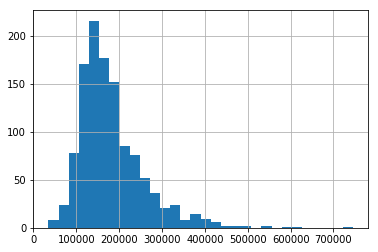

In [16]:
prices.hist(bins=30);

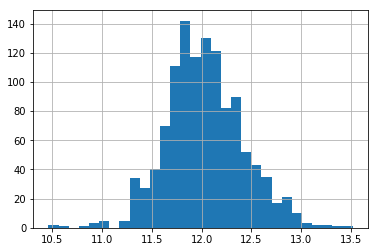

In [17]:
log_prices = np.log(prices)
log_prices.hist(bins=30);

In [18]:
lin_reg = LinearRegression()
tree_reg = DecisionTreeRegressor(random_state=42)
forest_reg = RandomForestRegressor(random_state=42)

In [19]:
scores = cross_val_score(forest_reg, housing_prepared, log_prices,
                         scoring="neg_mean_squared_error", cv=10)
np.sqrt(-scores)

array([0.13887954, 0.17925737, 0.16370275, 0.19189405, 0.15628206,
       0.21071561, 0.15433128, 0.14478114, 0.12874728, 0.11992552])

In [20]:
scores = cross_val_score(forest_reg, housing_prepared, prices,
                         scoring="neg_mean_squared_log_error", cv=10)
np.sqrt(-scores)

array([0.12269441, 0.18210824, 0.13768506, 0.20589299, 0.17348785,
       0.20254617, 0.15999006, 0.15858212, 0.13887501, 0.12133764])

In [21]:
prices_test = test_set.SalePrice
log_prices_test = np.log(prices_test)
housing_test = test_set.drop("SalePrice", axis=1)

housing_test_trans = full_pipeline.transform(housing_test)
housing_test_trans.shape

(292, 340)

In [22]:
for name, model in [('linear', lin_reg), ('tree', tree_reg), ('forest', forest_reg)]:
    model.fit(housing_prepared, log_prices)
    pred = model.predict(housing_test_trans)
    score = np.sqrt(mean_squared_error(pred, log_prices_test))
    print(f'{name}: {score:.3f}')

linear: 0.237
tree: 0.214
forest: 0.164


In [48]:
param_grid = {'n_estimators': [120, 150, 180], 'max_features': [14, 16, 18, 20]}

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, log_prices)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [120, 150, 180], 'max_features': [14, 16, 18, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [49]:
grid_search.best_params_

{'max_features': 20, 'n_estimators': 180}

In [50]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("{:2f}, {}".format(np.sqrt(-mean_score), params))

0.154462, {'max_features': 14, 'n_estimators': 120}
0.154155, {'max_features': 14, 'n_estimators': 150}
0.154112, {'max_features': 14, 'n_estimators': 180}
0.153774, {'max_features': 16, 'n_estimators': 120}
0.154087, {'max_features': 16, 'n_estimators': 150}
0.153675, {'max_features': 16, 'n_estimators': 180}
0.152463, {'max_features': 18, 'n_estimators': 120}
0.152239, {'max_features': 18, 'n_estimators': 150}
0.152035, {'max_features': 18, 'n_estimators': 180}
0.152342, {'max_features': 20, 'n_estimators': 120}
0.151818, {'max_features': 20, 'n_estimators': 150}
0.151295, {'max_features': 20, 'n_estimators': 180}


# Submission

In [59]:
pipeline_with_predict = Pipeline([('preparation', full_pipeline),
                                 ('forest', RandomForestRegressor(n_estimators=180, max_features=20))])
np.sqrt(-cross_val_score(pipeline_with_predict, housing, log_prices,
                         scoring="neg_mean_squared_error", cv=10))

array([0.11121406, 0.16981406, 0.14336943, 0.17123727, 0.15938259,
       0.20461408, 0.1472889 , 0.14888975, 0.13558417, 0.12049946])

In [60]:
pipeline_with_predict.fit(housing, log_prices)

Pipeline(memory=None,
     steps=[('preparation', FeatureUnion(n_jobs=1,
       transformer_list=[('cat_pipeline', Pipeline(memory=None,
     steps=[('selector', DFSelector(cols=['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condit...imators=180, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [61]:
results = pd.DataFrame({'Id': test.Id, 'SalePrice': np.exp(pipeline_with_predict.predict(test))})
results.to_csv(HOUSING_DATA_PATH / 'submission.csv', index=False)
results.head()

,Id,SalePrice
0,1461,122737.415566
1,1462,153575.023612
2,1463,187213.645413
3,1464,192257.619640
4,1465,193835.045524
